# Machine Unlearning Research Assignment


In [1]:
!pip install timm scikit-learn pandas matplotlib

In [3]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import torchvision
import torchvision.transforms as transforms
from torch.utils.data import DataLoader, Subset
from torch.optim.lr_scheduler import CosineAnnealingLR
import timm
import copy
import numpy as np
import random
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.manifold import TSNE
from scipy.spatial.distance import jensenshannon
import pandas as pd
from tqdm import tqdm

In [4]:
class Config:
    DEVICE = 'cuda' if torch.cuda.is_available() else 'cpu'
    SEED = 42
    
    # Target Class to Unlearn (0: Airplane)
    FORGET_CLASS = 0  
    
    # Model & Data Config
    MODEL_NAME = 'vit_tiny_patch16_224' 
    NUM_CLASSES = 10
    BATCH_SIZE = 64
    
    # Training Hyperparameters
    LR_TRAIN = 1e-4
    LR_UNLEARN = 1e-4
    
    NUM_WORKERS = 0
    
    EPOCHS_TRAIN = 3    # For Original/Gold training
    EPOCHS_UNLEARN = 5  # For Unlearning process

def set_seed(seed):
    """Sets the seed for reproducibility."""
    torch.manual_seed(seed)
    np.random.seed(seed)
    random.seed(seed)
    if torch.cuda.is_available():
        torch.cuda.manual_seed_all(seed)

set_seed(Config.SEED)
print(f"System Ready. Device: {Config.DEVICE}")

System Ready. Device: cuda


In [5]:
def get_dataloaders(forget_class_idx):
    """
    Prepares DataLoaders.
    - Adds 'all' loader for training the Original Model properly.
    """
    print(f"Preparing Data... (Target Class: {forget_class_idx})")
    
    # Preprocessing
    transform = transforms.Compose([
        transforms.Resize((224, 224)),
        transforms.ToTensor(),
        transforms.Normalize([0.5, 0.5, 0.5], [0.5, 0.5, 0.5])
    ])
    
    # Load raw datasets
    train_set = torchvision.datasets.CIFAR10(root='./data', train=True, download=True, transform=transform)
    test_set = torchvision.datasets.CIFAR10(root='./data', train=False, download=True, transform=transform)
    
    # --- Split Indices ---
    targets = np.array(train_set.targets)
    idx_forget = np.where(targets == forget_class_idx)[0]
    idx_retain = np.where(targets != forget_class_idx)[0]
    idx_all = np.arange(len(targets)) # Use ALL indices for Original Model
    
    # Test Indices
    test_targets = np.array(test_set.targets)
    idx_test_forget = np.where(test_targets == forget_class_idx)[0]
    idx_test_retain = np.where(test_targets != forget_class_idx)[0]
    
    loaders = {
        'all': DataLoader(Subset(train_set, idx_all), batch_size=Config.BATCH_SIZE, shuffle=True, num_workers=Config.NUM_WORKERS), # FIXED
        'forget': DataLoader(Subset(train_set, idx_forget), batch_size=Config.BATCH_SIZE, shuffle=True, num_workers=Config.NUM_WORKERS),
        'retain': DataLoader(Subset(train_set, idx_retain), batch_size=Config.BATCH_SIZE, shuffle=True, num_workers=Config.NUM_WORKERS),
        'test_forget': DataLoader(Subset(test_set, idx_test_forget), batch_size=Config.BATCH_SIZE, shuffle=False, num_workers=Config.NUM_WORKERS),
        'test_retain': DataLoader(Subset(test_set, idx_test_retain), batch_size=Config.BATCH_SIZE, shuffle=False, num_workers=Config.NUM_WORKERS),
    }
    return loaders

def get_model():
    model = timm.create_model(Config.MODEL_NAME, pretrained=True)
    model.head = nn.Linear(model.head.in_features, Config.NUM_CLASSES)
    return model.to(Config.DEVICE)

loaders = get_dataloaders(Config.FORGET_CLASS)

Preparing Data... (Target Class: 0)
Files already downloaded and verified
Files already downloaded and verified


In [6]:
# --- 1. Accuracy (Train/Test split) ---
def evaluate_accuracy(model, loaders):
    """Computes accuracy on Train(Forget/Retain) and Test(Forget/Retain)"""
    model.eval()
    results = {}
    
    # Iterate over each loader (Forget Train, Retain Train, Forget Test, etc.)
    for key, loader in loaders.items():
        correct = 0
        total = 0
        
        # [Added] tqdm for visualization
        # leave=False: Removes the bar after completion to keep notebook clean
        pbar = tqdm(loader, desc=f"Eval Acc [{key}]", leave=False)
        
        with torch.no_grad():
            for data, target in pbar:
                data, target = data.to(Config.DEVICE), target.to(Config.DEVICE)
                outputs = model(data)
                preds = outputs.argmax(dim=1)
                correct += (preds == target).sum().item()
                total += target.size(0)
                
                # Optional: Show current acc in progress bar
                current_acc = 100 * correct / total
                pbar.set_postfix({'acc': f'{current_acc:.2f}%'})
            
            results[f'{key}_acc'] = 100 * correct / total if total > 0 else 0
            
    return results

# --- 2. Entropy (Uncertainty) ---
def evaluate_entropy(model, loader):
    """Computes mean entropy"""
    model.eval()
    entropies = []
    
    # [Added] tqdm
    pbar = tqdm(loader, desc="Eval Entropy", leave=False)
    
    with torch.no_grad():
        for data, _ in pbar:
            data = data.to(Config.DEVICE)
            probs = F.softmax(model(data), dim=-1)
            e = -torch.sum(probs * torch.log(probs + 1e-9), dim=-1)
            entropies.extend(e.cpu().numpy())
            
    return np.mean(entropies)

# --- 3. JS Divergence (Distance to Gold Model) ---
def compute_jsd(model_target, model_gold, loader):
    """Computes Jensen-Shannon Divergence"""
    model_target.eval()
    model_gold.eval()
    js_dists = []
    
    # [Added] tqdm
    pbar = tqdm(loader, desc="Eval JSD", leave=False)
    
    with torch.no_grad():
        for data, _ in pbar:
            data = data.to(Config.DEVICE)
            p = F.softmax(model_target(data), dim=-1).cpu().numpy()
            q = F.softmax(model_gold(data), dim=-1).cpu().numpy()
            
            for i in range(len(p)):
                js_dists.append(jensenshannon(p[i], q[i]))
                
    return np.mean(js_dists)

# --- 4. t-SNE Visualization ---
def visualize_tsne(models_dict, loaders, title_prefix=""):
    """
    Generates t-SNE plots for multiple models
    """
    # Sample limited data for speed
    features_list, labels_list = [], []
    N_SAMPLES = 300
    
    # Collect data once
    data_samples = []
    print("Collecting data for t-SNE...")
    with torch.no_grad():
        # Get Retain samples
        cnt = 0
        for d, _ in tqdm(loaders['retain'], desc="Loading Retain", leave=False):
            if cnt >= N_SAMPLES: break
            data_samples.append((d, 'Retain'))
            cnt += len(d)
        # Get Forget samples
        cnt = 0
        for d, _ in tqdm(loaders['forget'], desc="Loading Forget", leave=False):
            if cnt >= N_SAMPLES: break
            data_samples.append((d, 'Forget'))
            cnt += len(d)

    # Plot setup
    fig, axes = plt.subplots(1, len(models_dict), figsize=(5 * len(models_dict), 5))
    if len(models_dict) == 1: axes = [axes]
    
    print("Running Inference & t-SNE...")
    # [Added] Loop through models with progress bar
    for ax, (name, model) in tqdm(zip(axes, models_dict.items()), total=len(models_dict), desc="Models"):
        model.eval()
        feats, groups = [], []
        
        with torch.no_grad():
            # [Added] Inference progress
            for batch, label in data_samples:
                batch = batch.to(Config.DEVICE)
                # Extract features (CLS token or flatten)
                f = model.forward_features(batch) # For ViT/ResNet (timm style)
                # Handle different output shapes (ViT: [B, Patch, D], ResNet: [B, D])
                if f.dim() == 3: f = f[:, 0, :]
                elif f.dim() == 4: f = f.mean(dim=[2, 3]) # Global Avg Pool for CNNs if needed
                
                feats.append(f.cpu().numpy())
                groups.extend([label] * len(batch))
        
        feats = np.concatenate(feats)
        
        # t-SNE fitting (can be slow, so we print a status)
        tsne = TSNE(n_components=2, random_state=42, perplexity=30, init='pca', learning_rate='auto')
        embedded = tsne.fit_transform(feats)
        
        sns.scatterplot(x=embedded[:,0], y=embedded[:,1], hue=groups, 
                        palette={'Retain': 'lightgrey', 'Forget': 'red'}, 
                        style=groups, ax=ax, s=60, alpha=0.7, legend=(ax == axes[-1]))
        ax.set_title(f"{name}")
        ax.axis('off')
        
    plt.tight_layout()
    plt.show()

In [7]:
 from tqdm.auto import tqdm  # Import progress bar

# --- Method 1: Fine-tuning (FT) ---
# Strategy: "Reinforce what we want to keep."
# We simply retrain the model on the Retain Set. 
# It is the safest baseline but can be slow or insufficient to remove specific memories.
def unlearn_finetune(model, loaders):
    print(">>> Running Fine-tuning (Retain Only)...")
    optimizer = optim.SGD(model.parameters(), lr=Config.LR_UNLEARN, momentum=0.9)
    criterion = nn.CrossEntropyLoss()
    model.train()
    
    # Outer loop for epochs
    for epoch in range(Config.EPOCHS_UNLEARN):
        # Progress bar for the Retain Set
        pbar = tqdm(loaders['retain'], desc=f"FT Epoch {epoch+1}/{Config.EPOCHS_UNLEARN}", leave=False)
        
        for data, target in pbar:
            data, target = data.to(Config.DEVICE), target.to(Config.DEVICE)
            optimizer.zero_grad()
            
            # Standard CrossEntropy Loss
            loss = criterion(model(data), target)
            loss.backward()
            optimizer.step()
            
            pbar.set_postfix({'loss': f'{loss.item():.4f}'})
            
    return model

# --- Method 2: Gradient Ascent (GA) ---
# Strategy: "Actively destroy the target knowledge."
# We maximize the loss on the Forget Set (Gradient Ascent).
# NOTE: This creates a high risk of "Catastrophic Forgetting" (destroying all knowledge).
def unlearn_gradient_ascent(model, loaders):
    print(">>> Running Gradient Ascent (Forget Only)...")
    optimizer = optim.SGD(model.parameters(), lr=Config.LR_UNLEARN, momentum=0.9)
    criterion = nn.CrossEntropyLoss()
    model.train()
    
    for epoch in range(Config.EPOCHS_UNLEARN):
        # Progress bar for the Forget Set
        pbar = tqdm(loaders['forget'], desc=f"GA Epoch {epoch+1}/{Config.EPOCHS_UNLEARN}", leave=False)
        
        for data, target in pbar:
            data, target = data.to(Config.DEVICE), target.to(Config.DEVICE)
            optimizer.zero_grad()
            
            # Maximize Loss -> Minimize Negative Loss
            # We assume no knowledge of Retain Set here (Naive approach)
            loss = -criterion(model(data), target)
            
            loss.backward()
            optimizer.step()
            
            pbar.set_postfix({'loss (max)': f'{-loss.item():.4f}'})
            
    return model

# --- Method 3: 2-Stage ---
# Strategy: "Confuse, then Separate & Heal."
# Stage 1: (KL Divergence to Uniform distribution)
# Stage 2: Contrastive Learning (Push Forget away from Retain)
def unlearn_2stage(model, loaders):
    print(">>> Running 2-Stage Unlearning...")
    model.train()
    optimizer = optim.SGD(model.parameters(), lr=Config.LR_UNLEARN, momentum=0.9)
    
    # [Stage 1] 
    # Objective: Make the model output uniform probabilities (random guess) for Forget Data.
    print("   [Stage 1]")
    for data, _ in loaders['forget']:
        data = data.to(Config.DEVICE)
        optimizer.zero_grad()
        out = model(data)
        
        # Target: Uniform Distribution (1/N)
        uniform = torch.full_like(out, 1.0/Config.NUM_CLASSES)
        
        # KL Divergence Loss
        loss = nn.KLDivLoss(reduction='batchmean')(F.log_softmax(out, dim=-1), uniform)
        loss.backward()
        optimizer.step()
        break # Only run 1 iteration to initially break the weights
        
    # [Stage 2] 
    print("   [Stage 2] ")
    iter_retain = iter(loaders['retain'])
    
    for epoch in range(Config.EPOCHS_UNLEARN):
        # Progress bar for the Forget Set loop
        pbar = tqdm(loaders['forget'], desc=f"Stage 2 Epoch {epoch+1}/{Config.EPOCHS_UNLEARN}", leave=False)
        
        for data_f, _ in pbar:
            # Get Retain Batch (Cycle through iterator)
            try:
                data_r, target_r = next(iter_retain)
            except StopIteration:
                iter_retain = iter(loaders['retain'])
                data_r, target_r = next(iter_retain)
            
            # Match batch sizes for matrix operations
            min_bs = min(len(data_f), len(data_r))
            data_f = data_f[:min_bs].to(Config.DEVICE)
            data_r = data_r[:min_bs].to(Config.DEVICE)
            target_r = target_r[:min_bs].to(Config.DEVICE)
            
            optimizer.zero_grad()
            
            # A. Contrastive Loss (Push Forget away from Retain)
            out_f = model(data_f)
            out_r = model(data_r).detach() # Detach Retain (act as static anchors)
            
            # Compute similarity matrix
            sim = out_f @ out_r.T / 1.15
            # Minimize similarity (Negative Log Softmax)
            loss_con = (-1 * F.log_softmax(sim, dim=-1)).mean()
            
            # B. Retain Loss (Maintain utility on Retain Set)
            loss_ret = F.cross_entropy(model(data_r), target_r)
            
            # Total Loss
            total_loss = loss_con + loss_ret
            total_loss.backward()
            optimizer.step()
            
            pbar.set_postfix({'loss': f'{total_loss.item():.4f}'})
            
    return model

In [8]:
def train_standard(model, loader, epochs, name="Model"):
    print(f"Training {name} on {Config.DEVICE}...")
    model.train()
    optimizer = optim.SGD(model.parameters(), lr=Config.LR_TRAIN, momentum=0.9)
    criterion = nn.CrossEntropyLoss()
    
    for epoch in range(epochs):
        total_loss = 0
        correct = 0
        total = 0
        
        
        pbar = tqdm(loader, desc=f"Epoch {epoch+1}/{epochs}", leave=True)
        
        for data, target in pbar:
            data, target = data.to(Config.DEVICE), target.to(Config.DEVICE)
            
            optimizer.zero_grad()
            outputs = model(data)
            loss = criterion(outputs, target)
            loss.backward()
            optimizer.step()
            
            
            total_loss += loss.item()
            _, predicted = outputs.max(1)
            total += target.size(0)
            correct += predicted.eq(target).sum().item()
            
            
            pbar.set_postfix({
                'Loss': f"{loss.item():.4f}", 
                'Acc': f"{100.*correct/total:.2f}%"
            })
            
    return model

# 1. Original Model (Trained on ALL Data: Retain + Forget)
# This simulates the "Infected" model that knows everything.
print("--- [1/2] Training Original Model (All Classes) ---")
model_orig = get_model()
model_orig = train_standard(model_orig, loaders['all'], Config.EPOCHS_TRAIN, "Original Model")

# 2. Gold Standard (Trained on Retain Only)
# This simulates the "Clean" model that never saw the target class.
print("\n--- [2/2] Training Gold Standard (Retain Only) ---")
model_gold = get_model()
model_gold = train_standard(model_gold, loaders['retain'], Config.EPOCHS_TRAIN, "Gold Model")

--- [1/2] Training Original Model (All Classes) ---
Training Original Model on cuda...


Epoch 1/3:   0%|          | 0/782 [00:00<?, ?it/s]

Epoch 2/3:   0%|          | 0/782 [00:00<?, ?it/s]

Epoch 3/3:   0%|          | 0/782 [00:00<?, ?it/s]


--- [2/2] Training Gold Standard (Retain Only) ---
Training Gold Model on cuda...


Epoch 1/3:   0%|          | 0/704 [00:00<?, ?it/s]

Epoch 2/3:   0%|          | 0/704 [00:00<?, ?it/s]

Epoch 3/3:   0%|          | 0/704 [00:00<?, ?it/s]

In [9]:
print("Applying Unlearning Methods...")

# 1. Fine-tuning
model_ft = copy.deepcopy(model_orig)
model_ft = unlearn_finetune(model_ft, loaders)

# 2. Gradient Ascent
model_ga = copy.deepcopy(model_orig)
model_ga = unlearn_gradient_ascent(model_ga, loaders)

# 3. 2-Stage
model_2stage = copy.deepcopy(model_orig)
model_2stage = unlearn_2stage(model_2stage, loaders)

# Dictionary for easy iteration
models = {
    "Original": model_orig,
    "Gold Standard": model_gold,
    "Fine-tuning": model_ft,
    "Gradient Ascent": model_ga,
    "2-Stage (Ours)": model_2stage
}

Applying Unlearning Methods...
>>> Running Fine-tuning (Retain Only)...


FT Epoch 1/5:   0%|          | 0/704 [00:00<?, ?it/s]

FT Epoch 2/5:   0%|          | 0/704 [00:00<?, ?it/s]

FT Epoch 3/5:   0%|          | 0/704 [00:00<?, ?it/s]

FT Epoch 4/5:   0%|          | 0/704 [00:00<?, ?it/s]

FT Epoch 5/5:   0%|          | 0/704 [00:00<?, ?it/s]

>>> Running Gradient Ascent (Forget Only)...


GA Epoch 1/5:   0%|          | 0/79 [00:00<?, ?it/s]

GA Epoch 2/5:   0%|          | 0/79 [00:00<?, ?it/s]

GA Epoch 3/5:   0%|          | 0/79 [00:00<?, ?it/s]

GA Epoch 4/5:   0%|          | 0/79 [00:00<?, ?it/s]

GA Epoch 5/5:   0%|          | 0/79 [00:00<?, ?it/s]

>>> Running 2-Stage Unlearning...
   [Stage 1]
   [Stage 2] 


Stage 2 Epoch 1/5:   0%|          | 0/79 [00:00<?, ?it/s]

Stage 2 Epoch 2/5:   0%|          | 0/79 [00:00<?, ?it/s]

Stage 2 Epoch 3/5:   0%|          | 0/79 [00:00<?, ?it/s]

Stage 2 Epoch 4/5:   0%|          | 0/79 [00:00<?, ?it/s]

Stage 2 Epoch 5/5:   0%|          | 0/79 [00:00<?, ?it/s]

In [10]:
results = []

print(f"{'Method':<20} | {'Forget Acc':<10} | {'Retain Acc':<10} | {'Entropy (F)':<12} | {'JSD (vs Gold)':<12}")
print("-" * 75)

for name, model in models.items():
    # 1. Accuracy
    accs = evaluate_accuracy(model, loaders)
    
    # 2. Entropy (on Test Forget)
    ent = evaluate_entropy(model, loaders['test_forget'])
    
    # 3. JS Divergence (vs Gold Model on Test Forget)
    jsd = compute_jsd(model, model_gold, loaders['test_forget'])
    
    # Store and Print
    row = {
        "Method": name,
        "Forget Acc (Train)": accs['forget_acc'],
        "Retain Acc (Test)": accs['test_retain_acc'],
        "Entropy": ent,
        "JSD": jsd
    }
    results.append(row)
    
    print(f"{name:<20} | {accs['forget_acc']:<10.2f} | {accs['test_retain_acc']:<10.2f} | {ent:<12.4f} | {jsd:<12.4f}")

# Convert to DataFrame for easier viewing
df_results = pd.DataFrame(results)


Method               | Forget Acc | Retain Acc | Entropy (F)  | JSD (vs Gold)
---------------------------------------------------------------------------


Eval Acc [all]:   0%|          | 0/782 [00:00<?, ?it/s]

Eval Acc [forget]:   0%|          | 0/79 [00:00<?, ?it/s]

Eval Acc [retain]:   0%|          | 0/704 [00:00<?, ?it/s]

Eval Acc [test_forget]:   0%|          | 0/16 [00:00<?, ?it/s]

Eval Acc [test_retain]:   0%|          | 0/141 [00:00<?, ?it/s]

Eval Entropy:   0%|          | 0/16 [00:00<?, ?it/s]

Eval JSD:   0%|          | 0/16 [00:00<?, ?it/s]

Original             | 98.94      | 96.08      | 0.0867       | 0.7961      


Eval Acc [all]:   0%|          | 0/782 [00:00<?, ?it/s]

Eval Acc [forget]:   0%|          | 0/79 [00:00<?, ?it/s]

Eval Acc [retain]:   0%|          | 0/704 [00:00<?, ?it/s]

Eval Acc [test_forget]:   0%|          | 0/16 [00:00<?, ?it/s]

Eval Acc [test_retain]:   0%|          | 0/141 [00:00<?, ?it/s]

Eval Entropy:   0%|          | 0/16 [00:00<?, ?it/s]

Eval JSD:   0%|          | 0/16 [00:00<?, ?it/s]

Gold Standard        | 0.00       | 96.31      | 0.6868       | 0.0000      


Eval Acc [all]:   0%|          | 0/782 [00:00<?, ?it/s]

Eval Acc [forget]:   0%|          | 0/79 [00:00<?, ?it/s]

Eval Acc [retain]:   0%|          | 0/704 [00:00<?, ?it/s]

Eval Acc [test_forget]:   0%|          | 0/16 [00:00<?, ?it/s]

Eval Acc [test_retain]:   0%|          | 0/141 [00:00<?, ?it/s]

Eval Entropy:   0%|          | 0/16 [00:00<?, ?it/s]

Eval JSD:   0%|          | 0/16 [00:00<?, ?it/s]

Fine-tuning          | 78.28      | 96.47      | 0.3097       | 0.6515      


Eval Acc [all]:   0%|          | 0/782 [00:00<?, ?it/s]

Eval Acc [forget]:   0%|          | 0/79 [00:00<?, ?it/s]

Eval Acc [retain]:   0%|          | 0/704 [00:00<?, ?it/s]

Eval Acc [test_forget]:   0%|          | 0/16 [00:00<?, ?it/s]

Eval Acc [test_retain]:   0%|          | 0/141 [00:00<?, ?it/s]

Eval Entropy:   0%|          | 0/16 [00:00<?, ?it/s]

Eval JSD:   0%|          | 0/16 [00:00<?, ?it/s]

Gradient Ascent      | 0.00       | 11.11      | 0.0000       | 0.5565      


Eval Acc [all]:   0%|          | 0/782 [00:00<?, ?it/s]

Eval Acc [forget]:   0%|          | 0/79 [00:00<?, ?it/s]

Eval Acc [retain]:   0%|          | 0/704 [00:00<?, ?it/s]

Eval Acc [test_forget]:   0%|          | 0/16 [00:00<?, ?it/s]

Eval Acc [test_retain]:   0%|          | 0/141 [00:00<?, ?it/s]

Eval Entropy:   0%|          | 0/16 [00:00<?, ?it/s]

Eval JSD:   0%|          | 0/16 [00:00<?, ?it/s]

2-Stage (Ours)       | 1.02       | 76.93      | 2.2814       | 0.5922      


Generating t-SNE Visualization...


Loading Retain:   0%|          | 0/704 [00:00<?, ?it/s]

Loading Forget:   0%|          | 0/79 [00:00<?, ?it/s]

Running Inference & t-SNE...


Models:   0%|          | 0/5 [00:00<?, ?it/s]

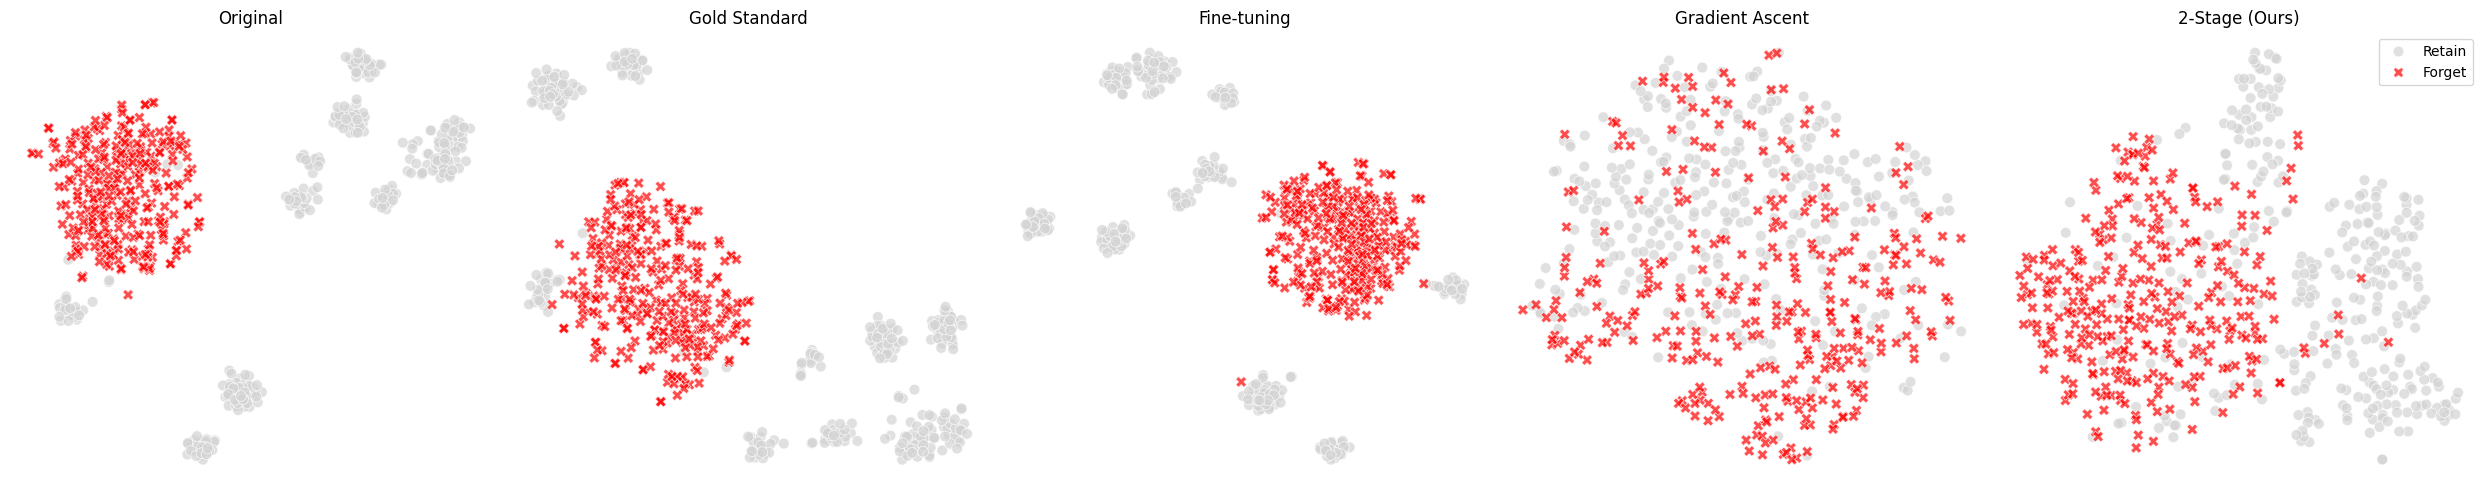

In [11]:
print("Generating t-SNE Visualization...")

# Visualize all 5 models side-by-side
visualize_tsne(models, loaders)